# Trying to generate Music with JSBChorales using VAE

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam

import numpy as np
import matplotlib.pyplot as plt
import joblib
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
datas = joblib.load("/kaggle/input/holedbach/jsb1-li-train.pkl")
X = datas['X']
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2]) # to 1 channel

from torch.utils.data import DataLoader

dataloader = DataLoader(X, batch_size=64, shuffle=True)


In [6]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = 0 - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [8]:
class BachBlock(nn.Module):
    def __init__(self, heads=1):
        super().__init__()
        layers = []

        for head in range(heads):
            layers.append(nn.Conv2d(1, 64, kernel_size=(16, 16), padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Conv2d(64, 64, kernel_size=(8, 8), padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Conv2d(64, 1, kernel_size=(4, 4), padding='same'))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))

        self.mod = nn.Sequential(*layers)

    def forward(self, x):
        x = self.mod(x) + x
        return x


class BachVAE(nn.Module):
    def __init__(self):
        super(BachVAE, self).__init__()
        self.preprocesser = BachBlock(8)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(16, 16), stride=(4, 2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=(8, 8), stride=(2, 2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 2, kernel_size=(4, 4)),
            nn.LeakyReLU(0.2)
        )

        self.d1 = nn.Dropout(0.2)
        self.ztodec = nn.Linear(32, 1024)

        self.mean_layer = nn.Linear(240, 32)
        self.logvar_layer = nn.Linear(240, 32)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 256, kernel_size=(4, 4)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 256, kernel_size=(9, 7), stride=(2, 2)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 1, kernel_size=(16, 16), stride=(4, 2)),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.d1(x)
        x = x.flatten(1)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        var = torch.exp(logvar)
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        z = self.ztodec(z)
        z = z.view(z.shape[0], 8, 8, 16)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


model = BachVAE().to(device)
optim = Adam(model.parameters(), lr=0.001)
criterion = loss_function

if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model).cuda()



Let's use 2 GPUs!


In [10]:
model.train()
for epoch in range(200):
    for batch_idx, x in enumerate(dataloader):
        x = x.float().to(device)
        optim.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        loss.backward()
        optim.step()

    print(epoch, loss.item())

0 55428.88671875
1 53999.21875
2 53430.48828125
3 53253.16015625
4 48323.27734375
5 46690.3359375
6 46562.4296875
7 45675.4609375
8 45307.74609375
9 44931.43359375
10 44992.2109375
11 44677.58203125
12 44113.37890625
13 43982.44921875
14 42752.26953125
15 43111.109375
16 42703.9921875
17 43393.953125
18 42880.43359375
19 41987.98828125
20 41211.90234375
21 41233.51171875
22 40489.98046875
23 41073.91015625
24 40633.83984375
25 40225.90625
26 39362.140625
27 39641.640625
28 39663.01953125
29 39462.7109375
30 39214.6953125
31 38383.20703125
32 38250.45703125
33 37521.21484375
34 38064.5
35 36885.59375
36 36222.375
37 36711.66796875
38 37067.4609375
39 36110.7578125
40 36703.8359375
41 34163.953125
42 34468.21875
43 35870.890625
44 35237.11328125
45 33341.0703125
46 33741.1328125
47 33715.31640625
48 31839.94140625
49 32504.294921875
50 31901.484375
51 32635.5078125
52 32632.3359375
53 32119.06640625
54 30435.86328125
55 30437.34765625
56 30896.916015625
57 31081.361328125
58 29904.878906

torch.Size([44, 1, 128, 100])


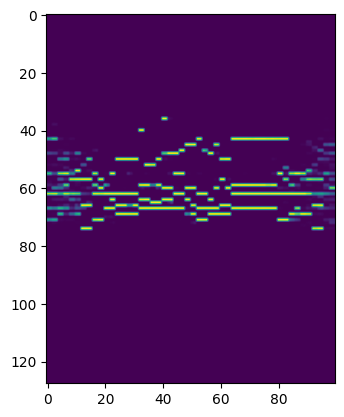

In [11]:
model.eval()
with torch.no_grad():
    _x = x.float().to(device)
    _x_hat, mean, log_var = model(_x)

_x_hat = _x_hat.cpu().numpy()[2, 0, :, :]
print(x_hat.shape)
plt.imshow(_x_hat)

# Generating Samples from learned Distribution

In [12]:
def generate_sample_distr(z_sample): # 8, 8, 16
    # z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    sample = x_decoded.detach().cpu().reshape(128, 100) # reshape vector to 2d array
    plt.imshow(sample)
    plt.axis('off')
    plt.show()
    return sample

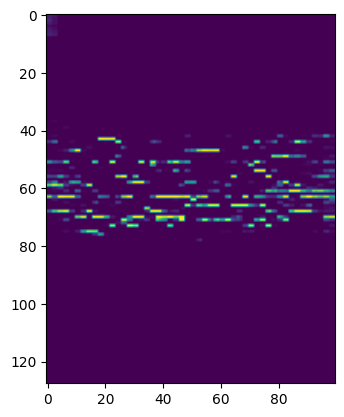

In [13]:
with torch.no_grad():
    mean = torch.randn(1, 32).to(device)*-0.1
    logvar = torch.randn(1, 32).to(device)*0.3
    z = model.module.reparameterization(mean, logvar)
    z = model.module.ztodec(z)
    z = z.view(z.shape[0], 8, 8, 16)
    new_sample = model.module.decode(z)

new_sample = new_sample.cpu().numpy()[0, 0, :, :]

plt.imshow(new_sample)

### Per quanto è ancora molto basilare è promettente (credo)

In [ ]:
torch.save(model.state_dict(), "BachVAE1.pt")


In [ ]:
model.load_state_dict(torch.load("/kaggle/working/BachVAE1.pt", weights_only=True))
model.eval()